# FAIR model tests

example here: https://docs.fairmodel.net/en/latest/examples/calibrated_constrained_ensemble.html

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os

from fair import FAIR
from fair.interface import fill, initialise
from fair.io import read_properties

import random

/tmp/ipykernel_13739/1441259360.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/home/fedef/miniforge3/envs/climtools/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import fair
fair.__version__

'2.2.1'

### Create model

In [4]:
# Define number of ensemble members
n_ens = 500
ok_config = 'central' #f.define_configs(['high', 'central', 'low'])
allscen = ['zero_emiss', 'rampdown_40', 'jumpramp_20', 'bau10_ramp40', 'bau']
ens_names = ['ens{:03d}'.format(i) for i in range(n_ens)]

y_end = 2200
y_ini = 2025

f = FAIR()
f.define_time(1750, y_end, 1)
f.define_scenarios(allscen)
f.define_configs(['ens{:03d}'.format(i) for i in range(n_ens)])

# Select only basic species
species, properties = read_properties('fair_data/species_configs_properties.csv')
properties['CH4']['input_mode'] = 'emissions' # Set ch4 and n2o in emission mode
properties['N2O']['input_mode'] = 'emissions'
f.define_species(species, properties)

# For all species run:
# species_all, properties_all = read_properties()

# Defines the model
f.allocate()

f.fill_species_configs('fair_data/species_configs_properties.csv')

### Select parameters and create ensemble

In [5]:
# Step 1: Read the existing CSV file
input_file = 'fair_data/basic_run_example/configs_ensemble.csv'  # Specify your input file name
df = pd.read_csv(input_file)

# Step 2: Extract the central sensitivity setup (high, central, low)
params = df[df.iloc[:, 0] == 'central']

random_seeds = np.array([random.randint(1, 1e7) for i in range(n_ens)])
new_data = {col: [params[col].values[0]] * n_ens if col != 'seed' else random_seeds for col in df.columns}
new_data['Unnamed: 0'] = ens_names # names
ensemble = pd.DataFrame(new_data)


if not os.path.exists('fair_data/ensemble/'): os.mkdir('fair_data/ensemble/')
output_file = f'fair_data/ensemble/configs_central_n{n_ens}.csv'  # Specify your output file name
ensemble.to_csv(output_file, index=False)

print(f"\nNew data written to {output_file}")



New data written to fair_data/ensemble/configs_central_n500.csv


In [6]:
f.override_defaults(f'fair_data/ensemble/configs_central_n{n_ens}.csv')

### Emissions

In [7]:
emission_all = pd.read_csv('/home/fedef/Research/git/explore-extensions/data/emissions/extensions_1750-2500.csv')

anni_hist = [('{:6.1f}'.format(i+0.5)) for i in range(1750, y_ini-1)]
print(np.unique(emission_all['scenario']))

emissions = dict()
for cos in ['CO2 FFI', 'CO2 AFOLU', 'Sulfur', 'CH4', 'N2O']:
    emissions[cos] = emission_all[(emission_all['variable'] == cos) & (emission_all['scenario'] == 'medium-overshoot')][anni_hist].values.squeeze()
    #print(emissions[cos].shape)

['high-extension' 'high-overshoot' 'low' 'medium-extension'
 'medium-overshoot' 'verylow' 'verylow-overshoot']


In [8]:
ifut = y_end - y_ini +1

fut_emiss = dict()
fut_emiss['zero_emiss'] = np.zeros(ifut)
fut_emiss['rampdown_40'] = np.append(np.linspace(1, 0, 40), np.zeros(ifut-40))
fut_emiss['jumpramp_20'] = np.append(np.linspace(0.7, 0, 20), np.zeros(ifut-20))
fut_emiss['bau10_ramp40'] = np.append(np.append(np.ones(10), np.linspace(1, 0, 40)), np.zeros(ifut-50))
fut_emiss['bau'] = np.ones(ifut)

allscen = fut_emiss.keys()

for scen in allscen:
    for cos in ['CO2 FFI', 'CO2 AFOLU', 'Sulfur', 'CH4', 'N2O']:
        # if cos != 'CO2 FFI':
        #     f.emissions.loc[{'specie': cos, 'scenario': scen}] = np.vstack(n_ens * [np.append(emissions[cos], np.zeros(76))]).T
        # else:
        # Now all emissions are proportional to the CO2 FFI
        f.emissions.loc[{'specie': cos, 'scenario': scen}] = np.vstack(n_ens * [np.append(emissions[cos], emissions[cos][-1]*fut_emiss[scen])]).T

f.forcing.loc[{'specie': 'Volcanic'}] = 0.
# f.concentration.loc[{'specie': 'CH4'}] = 1900.
# f.concentration.loc[{'specie': 'N2O'}] = 336.

### Initialize

In [104]:
# Define initial conditions
# from fair.interface import initialise

### Starting from present day.. doesn't work!
# initialise(f.concentration, 420, specie='CO2')
# initialise(f.concentration, 1900, specie='CH4')
# initialise(f.concentration, 336, specie='N2O')
# initialise(f.forcing, 0.7)
# initialise(f.temperature, 1.3)
# initialise(f.cumulative_emissions, 1000., specie = 'CO2') # 40.*50/2
# initialise(f.cumulative_emissions, 0., specie = 'CH4') # 40.*50/2
# initialise(f.cumulative_emissions, 0., specie = 'N2O') # 40.*50/2
# initialise(f.airborne_emissions, 140., specie = 'CO2')
# initialise(f.ocean_heat_content_change, 20e21)

In [9]:
# Starting from pre-industrial
from fair.interface import initialise

for cos in ['CO2', 'CH4', 'N2O']:
    initialise(f.concentration, f.species_configs.loc[{'specie': cos}].baseline_concentration[0], specie=cos)

initialise(f.forcing, 0.)
initialise(f.temperature, 0.)
initialise(f.cumulative_emissions, 0.)
initialise(f.ocean_heat_content_change, 0.)

In [10]:
f.run()

Running 2500 projections in parallel: 100%|██████████| 450/450 [00:02<00:00, 155.82timesteps/s]


In [11]:
colors = ['steelblue', 'orange', 'forestgreen', 'indianred', 'violet']

In [21]:
def plot_scen(istart = 2000, iend = y_end, yave = 5, do_rolling = True):
    iro = 0
    if do_rolling: iro = yave

    fig, ax = plt.subplots(figsize = (16,9))
    for scen, col in zip(list(allscen)[::-1], colors[::-1]):
        mean = f.temperature.sel(scenario = scen, layer = 0, timebounds = slice(y_ini-iro, iend+iro)).mean(['config'])
        std = f.temperature.sel(scenario = scen, layer = 0, timebounds = slice(y_ini-iro, iend+iro)).std(['config'])
        if do_rolling:
            mean = mean.rolling(timebounds = yave, min_periods=yave//2, center=True).mean().sel(timebounds = slice(y_ini, iend))
            std = std.rolling(timebounds = yave, min_periods=yave//2, center=True).mean().sel(timebounds = slice(y_ini, iend))

        ax.fill_between(f.temperature.timebounds.sel(timebounds = slice(y_ini, iend)), mean-std, mean+std, color = col, alpha=0.3, edgecolor = 'none')
        ax.plot(f.temperature.timebounds.sel(timebounds = slice(y_ini, iend)), mean, color = col, lw = 3, label = scen)

    mean = f.temperature.sel(layer = 0, timebounds = slice(istart-iro, y_ini+1+iro)).mean(['config', 'scenario'])
    std = f.temperature.sel(layer = 0, timebounds = slice(istart-iro, y_ini+1+iro)).std(['config', 'scenario'])
    if do_rolling:
        mean = mean.rolling(timebounds = yave, min_periods=yave//2, center=True).mean().sel(timebounds = slice(istart, y_ini+1))
        std = std.rolling(timebounds = yave, min_periods=yave//2, center=True).mean().sel(timebounds = slice(istart, y_ini+1))

    col = 'grey'
    ax.fill_between(f.temperature.timebounds.sel(timebounds = slice(istart,y_ini+1)), mean-std, mean+std, color = col, alpha=0.1, edgecolor = 'none')
    ax.plot(f.temperature.timebounds.sel(timebounds = slice(istart,y_ini+1)), mean, label = 'hist', color = col, lw = 3)

    ax.axhline(1.5, color = 'red', ls = ':', lw = 0.5)
    #plt.title('Temperature change')
    plt.xlabel('year')
    plt.ylabel('Temperature anomaly (K)')
    plt.legend()
    plt.grid(color='gray', linestyle=':', linewidth=0.5)    
    plt.savefig(f'future_noemiss_bau_{istart}-{iend}.pdf')

    return

def plot_scen_vs_refscen(refscen, istart = 2025, iend = y_end, yave = 5, do_rolling = True):
    iro = 0
    if do_rolling: iro = yave

    fig, ax = plt.subplots(figsize = (16,9))
    col = 'violet'
    
    refmean = f.temperature.sel(scenario = refscen, layer = 0, timebounds = slice(y_ini-iro, iend+iro)).mean(['config'])
    refstd = f.temperature.sel(scenario = refscen, layer = 0, timebounds = slice(y_ini-iro, iend+iro)).std(['config'])
    if do_rolling:
        refmean = refmean.rolling(timebounds = yave, min_periods=yave//2, center=True).mean().sel(timebounds = slice(y_ini, iend))
        refstd = refstd.rolling(timebounds = yave, min_periods=yave//2, center=True).mean().sel(timebounds = slice(y_ini, iend))
    
    ax.fill_between(f.temperature.timebounds.sel(timebounds = slice(y_ini, iend)), -refstd, refstd, color = col, alpha=0.3, edgecolor = 'none')

    for scen, col in zip(list(allscen)[::-1], colors[::-1]):
        mean = f.temperature.sel(scenario = scen, layer = 0, timebounds = slice(y_ini-iro, iend+iro)).mean(['config'])
        # std = f.temperature.sel(scenario = scen, layer = 0, timebounds = slice(y_ini-iro, iend+iro)).std(['config'])
        if do_rolling:
            mean = mean.rolling(timebounds = yave, min_periods=yave//2, center=True).mean().sel(timebounds = slice(y_ini, iend))
            # std = std.rolling(timebounds = yave, min_periods=yave//2, center=True).mean().sel(timebounds = slice(y_ini, iend))

        ax.plot(f.temperature.timebounds.sel(timebounds = slice(y_ini, iend)), mean-refmean, color = col, lw = 3, label = scen)

    # mean = f.temperature.sel(layer = 0, timebounds = slice(istart-iro, y_ini+1+iro)).mean(['config', 'scenario'])
    # std = f.temperature.sel(layer = 0, timebounds = slice(istart-iro, y_ini+1+iro)).std(['config', 'scenario'])
    # if do_rolling:
    #     mean = mean.rolling(timebounds = yave, min_periods=yave//2, center=True).mean().sel(timebounds = slice(istart, y_ini+1))
    #     std = std.rolling(timebounds = yave, min_periods=yave//2, center=True).mean().sel(timebounds = slice(istart, y_ini+1))

    # col = 'grey'
    # ax.fill_between(f.temperature.timebounds.sel(timebounds = slice(istart,y_ini+1)), mean-std, mean+std, color = col, alpha=0.1, edgecolor = 'none')
    # ax.plot(f.temperature.timebounds.sel(timebounds = slice(istart,y_ini+1)), mean, label = 'hist', color = col, lw = 3)

    # ax.axhline(1.5, color = 'red', ls = ':', lw = 0.5)
    #plt.title('Temperature change')
    plt.xlabel('year')
    plt.ylabel('Temperature anomaly (K)')
    plt.legend()
    plt.grid(color='gray', linestyle=':', linewidth=0.5)    
    plt.savefig(f'future_tempanom_{istart}-{iend}.pdf')

    return

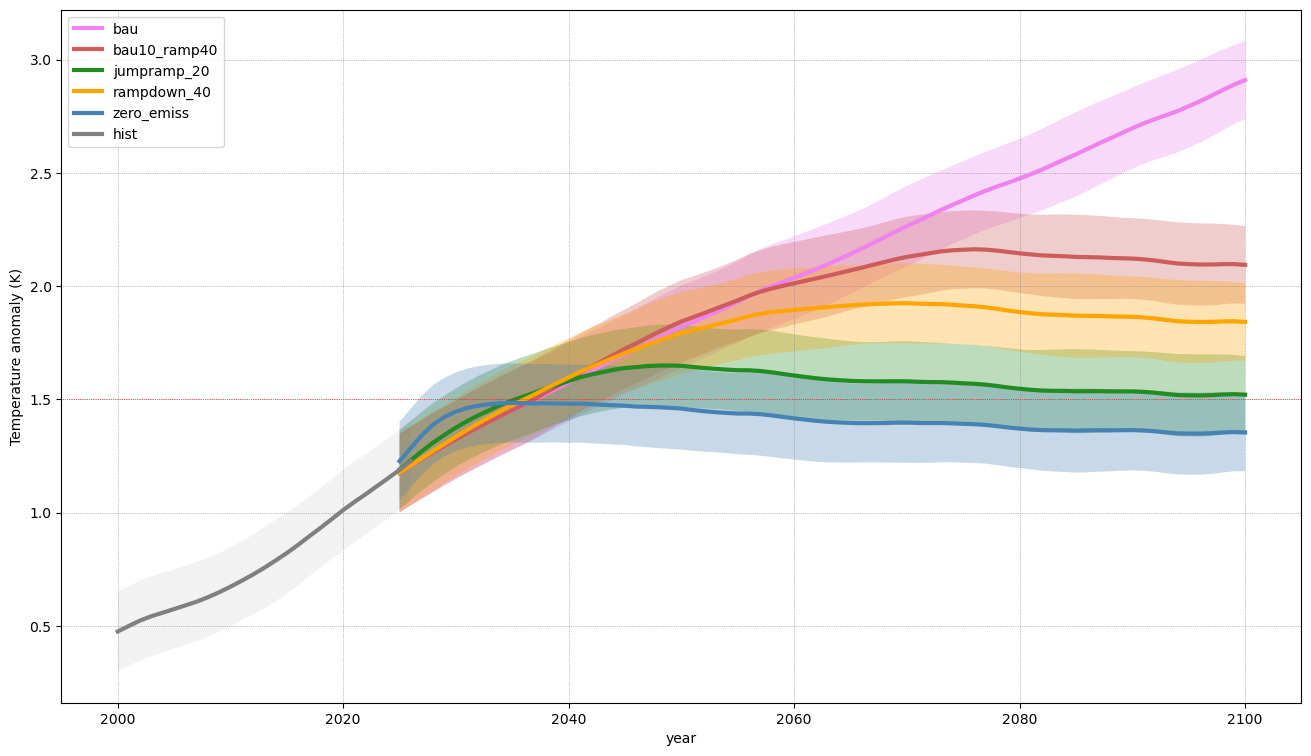

In [13]:
istart = 2000
iend = 2100
yave = 5
do_rolling = True

plot_scen(istart, iend, yave, do_rolling)

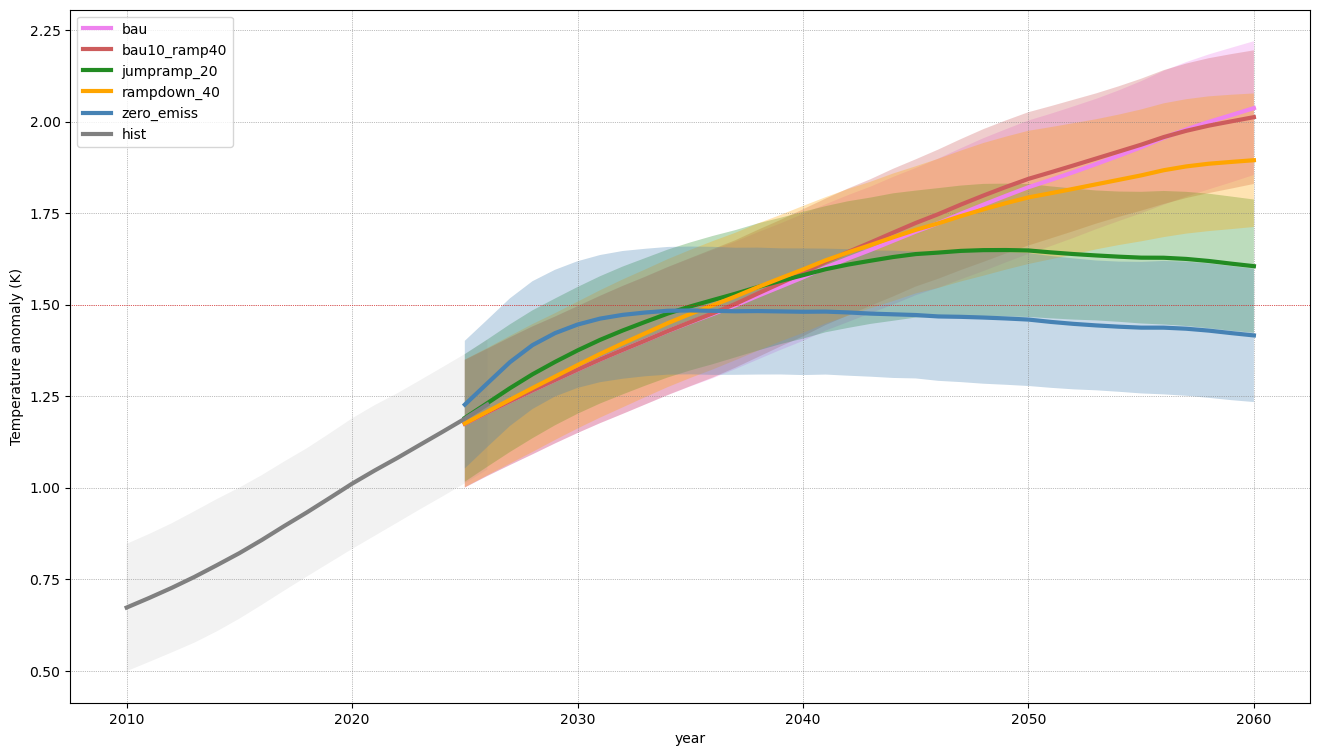

In [15]:
istart = 2010
iend = 2060
yave = 5
do_rolling = True

plot_scen(istart, iend, yave, do_rolling)

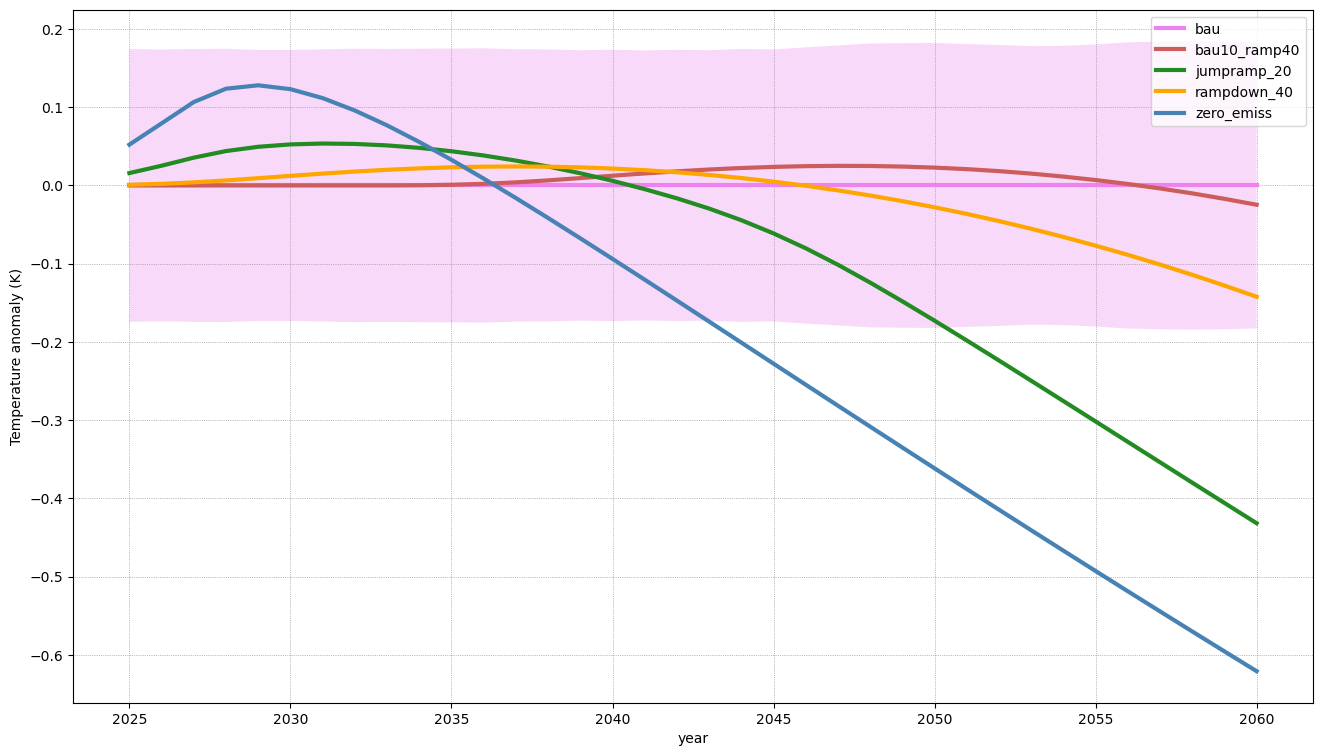

In [22]:
istart = 2025
iend = 2060
yave = 5
do_rolling = True

plot_scen_vs_refscen('bau', istart, iend, yave, do_rolling)

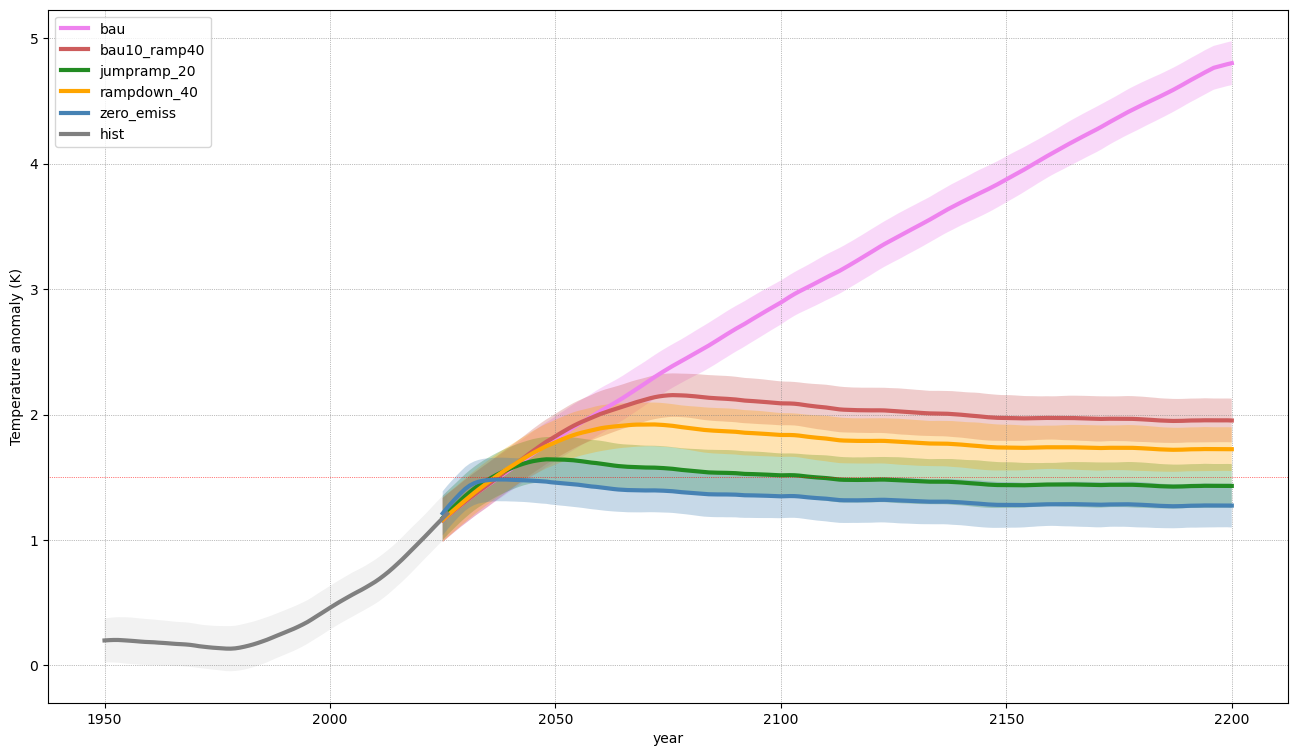

In [26]:
istart = 1950
iend = 2200
yave = 10
do_rolling = True

plot_scen(istart, iend, yave, do_rolling)

In [23]:
def plot_scen_wtrend(istart = 2000, iend = y_end, yave = 5):
    iro = yave

    fig, ax = plt.subplots(figsize = (16,9))
    for scen, col in zip(list(allscen)[::-1], colors[::-1]):
        mean = f.temperature.sel(scenario = scen, layer = 0, timebounds = slice(y_ini-iro, iend+iro)).rolling(timebounds = yave, min_periods=yave//2, center=True).mean().differentiate('timebounds').mean(['config']).sel(timebounds = slice(y_ini, iend))
        std = f.temperature.sel(scenario = scen, layer = 0, timebounds = slice(y_ini-iro, iend+iro)).rolling(timebounds = yave, min_periods=yave//2, center=True).mean().differentiate('timebounds').std(['config']).sel(timebounds = slice(y_ini, iend))

        ax.fill_between(f.temperature.timebounds.sel(timebounds = slice(y_ini, iend)), mean-std, mean+std, color = col, alpha=0.3, edgecolor = 'none')
        ax.plot(f.temperature.timebounds.sel(timebounds = slice(y_ini, iend)), mean, color = col, lw = 3, label = scen)

    mean = f.temperature.sel(layer = 0, timebounds = slice(istart-iro, y_ini+1+iro)).rolling(timebounds = yave, min_periods=yave//2, center=True).mean().differentiate('timebounds').mean(['config', 'scenario']).sel(timebounds = slice(istart, y_ini+1))
    std = f.temperature.sel(layer = 0, timebounds = slice(istart-iro, y_ini+1+iro)).rolling(timebounds = yave, min_periods=yave//2, center=True).mean().differentiate('timebounds').std(['config', 'scenario']).sel(timebounds = slice(istart, y_ini+1))

    col = 'grey'
    ax.fill_between(f.temperature.timebounds.sel(timebounds = slice(istart,y_ini+1)), mean-std, mean+std, color = col, alpha=0.1, edgecolor = 'none')
    ax.plot(f.temperature.timebounds.sel(timebounds = slice(istart,y_ini+1)), mean, label = 'hist', color = col, lw = 3)

    #plt.title('Temperature change')
    plt.xlabel('year')
    plt.ylabel('Temperature trend (K/yr)')
    plt.legend()
    plt.grid(color='gray', linestyle=':', linewidth=0.5)    
    plt.savefig(f'future_wtrend_{istart}-{iend}.pdf')

    return

def plot_scen_wtrend_vs_refscen(refscen, istart = 2025, iend = y_end, yave = 5):
    iro = yave

    fig, ax = plt.subplots(figsize = (16,9))
    col = 'violet'

    refmean = f.temperature.sel(scenario = refscen, layer = 0, timebounds = slice(y_ini-iro, iend+iro)).rolling(timebounds = yave, min_periods=yave//2, center=True).mean().differentiate('timebounds').mean(['config']).sel(timebounds = slice(y_ini, iend))
    refstd = f.temperature.sel(scenario = refscen, layer = 0, timebounds = slice(y_ini-iro, iend+iro)).rolling(timebounds = yave, min_periods=yave//2, center=True).mean().differentiate('timebounds').std(['config']).sel(timebounds = slice(y_ini, iend))

    ax.fill_between(f.temperature.timebounds.sel(timebounds = slice(y_ini, iend)), -refstd, refstd, color = col, alpha=0.3, edgecolor = 'none')

    for scen, col in zip(list(allscen)[::-1], colors[::-1]):
        mean = f.temperature.sel(scenario = scen, layer = 0, timebounds = slice(y_ini-iro, iend+iro)).rolling(timebounds = yave, min_periods=yave//2, center=True).mean().differentiate('timebounds').mean(['config']).sel(timebounds = slice(y_ini, iend))
        std = f.temperature.sel(scenario = scen, layer = 0, timebounds = slice(y_ini-iro, iend+iro)).rolling(timebounds = yave, min_periods=yave//2, center=True).mean().differentiate('timebounds').std(['config']).sel(timebounds = slice(y_ini, iend))

        ax.plot(f.temperature.timebounds.sel(timebounds = slice(y_ini, iend)), mean-refmean, color = col, lw = 3, label = scen)

    #plt.title('Temperature change')
    plt.xlabel('year')
    plt.ylabel('Temperature trend (K/yr)')
    plt.legend()
    plt.grid(color='gray', linestyle=':', linewidth=0.5)    
    plt.savefig(f'future_wtrend_{istart}-{iend}.pdf')

    return

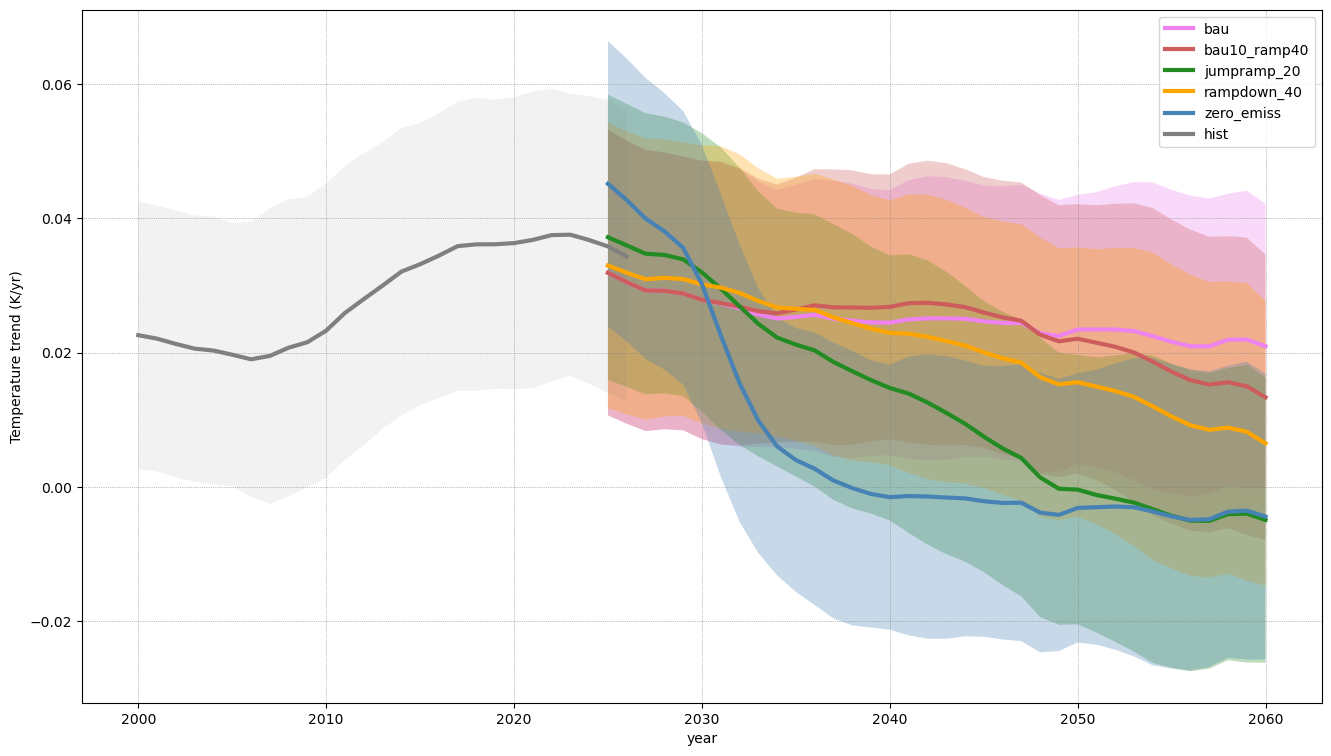

In [24]:
istart = 2000
iend = 2060
yave = 10

plot_scen_wtrend(istart, iend, yave)

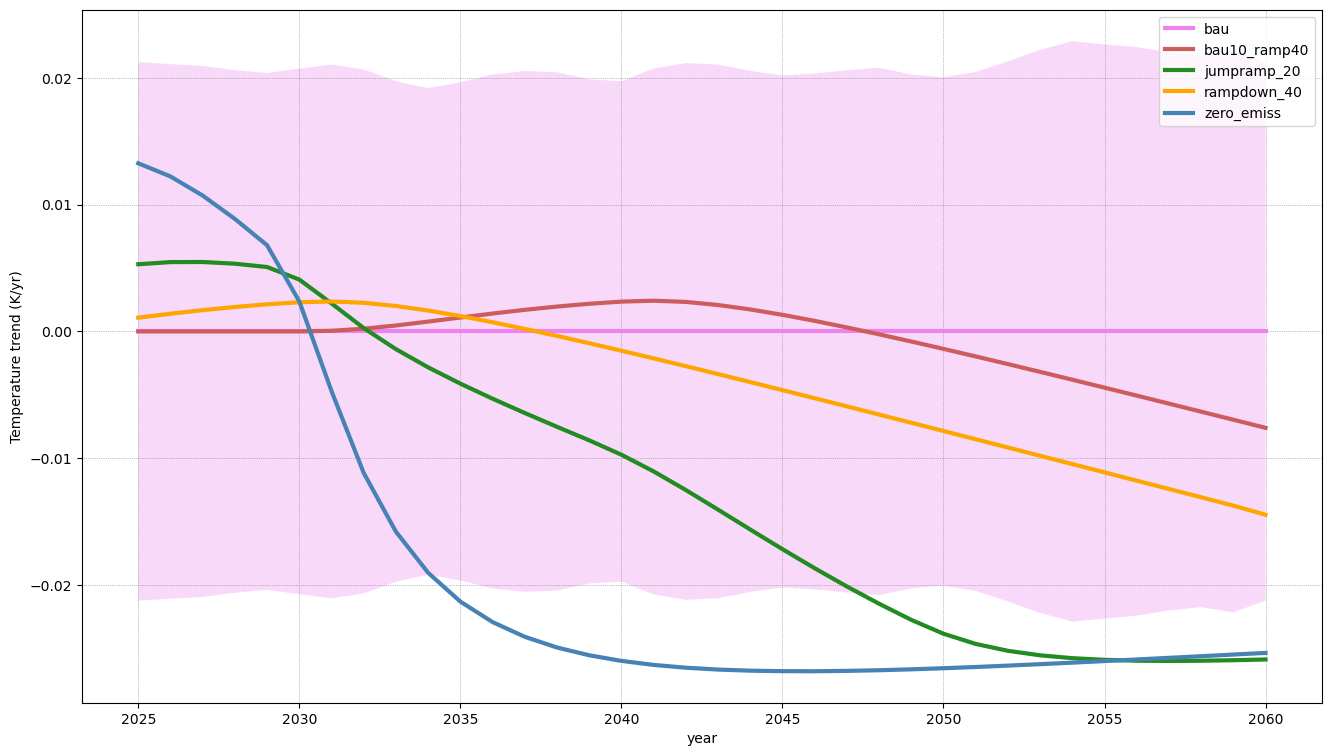

In [25]:
istart = 2025
iend = 2060
yave = 10

plot_scen_wtrend_vs_refscen('bau', istart, iend, yave)

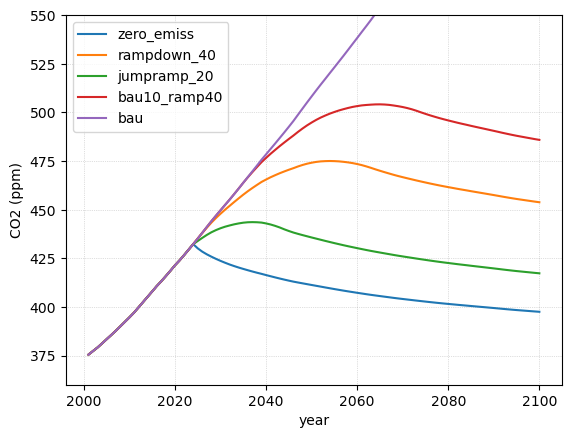

In [165]:
plt.plot(f.timebounds[-100:], f.concentration.sel(config = 'ens000', specie = 'CO2')[-100:], label=f.scenarios)
# plt.title('Zero emiss scenario: CO2')
plt.xlabel('year')
plt.ylabel('CO2 (ppm)')
plt.legend()
# plt.grid()
plt.grid(color='gray', linestyle=':', linewidth=0.5, alpha=0.5)  # Adjust alpha for transparency
plt.ylim(360, 550)

plt.savefig('scenarios_CO2_conc.pdf')


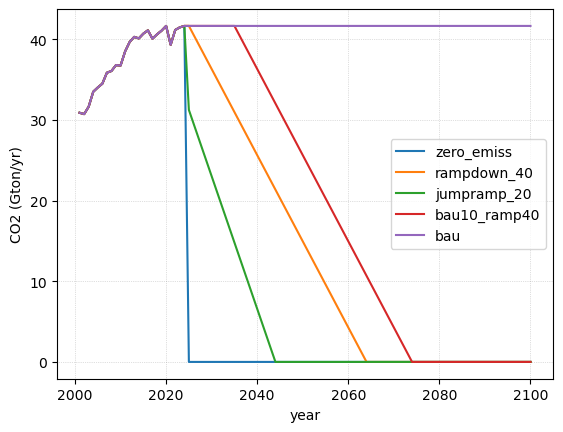

In [166]:
plt.plot(f.timebounds[-100:], f.emissions.sel(config = 'ens000', specie = 'CO2')[-100:], label=f.scenarios)
# plt.title('Emissions: CO2')
plt.xlabel('year')
plt.ylabel('CO2 (Gton/yr)')
plt.legend()
plt.grid(color='gray', linestyle=':', linewidth=0.5, alpha=0.5)
plt.savefig('scenarios_CO2_emiss.pdf')


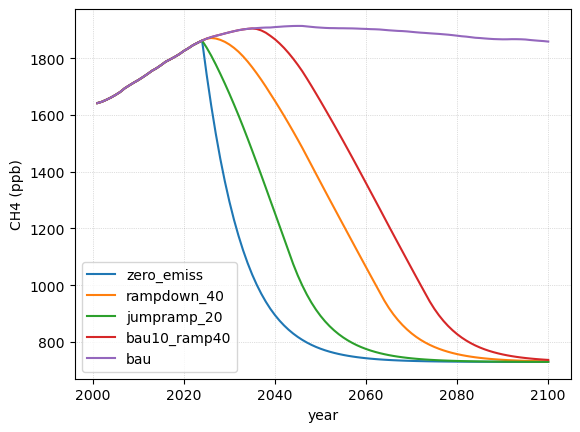

In [167]:
plt.plot(f.timebounds[-100:], f.concentration.sel(config = 'ens000', specie='CH4')[-100:], label=f.scenarios)
#plt.title('Zero emiss scenario: CH4')
plt.xlabel('year')
plt.ylabel('CH4 (ppb)')
plt.legend()
plt.grid(color='gray', linestyle=':', linewidth=0.5, alpha=0.5)
plt.savefig('scenarios_CH4_conc.pdf')


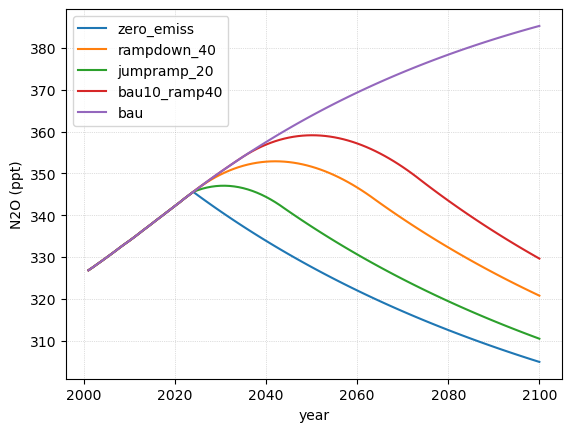

In [168]:
plt.plot(f.timebounds[-100:], f.concentration.sel(config = 'ens000', specie='N2O')[-100:], label=f.scenarios)
#plt.title('Zero emiss scenario: CH4')
plt.xlabel('year')
plt.ylabel('N2O (ppt)')
plt.legend()
plt.grid(color='gray', linestyle=':', linewidth=0.5, alpha=0.5)
plt.savefig('scenarios_N2O_conc.pdf')


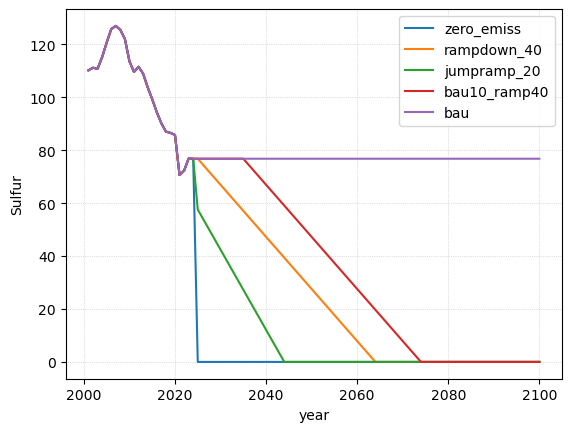

In [169]:
plt.plot(f.timebounds[-100:], f.emissions.sel(config = 'ens000', specie='Sulfur')[-100:], label=f.scenarios)
#plt.title('Zero emiss scenario: CH4')
plt.xlabel('year')
plt.ylabel('Sulfur')
plt.legend()
plt.grid(color='gray', linestyle=':', linewidth=0.5, alpha=0.5)
plt.savefig('scenarios_Sulfur_emiss.pdf')